In [ ]:
# Import library yang diperlukan, terutama fungsi-fungsi Spark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, when, isnull, isnan 
from pyspark.sql.types import StringType, IntegerType, FloatType, StructType, StructField

try:
    spark.stop()
except:
    pass

spark = SparkSession.builder \
    .appName("ChurnPredictionLargeMemory") \
    .config("spark.driver.memory", "12g") \
    .config("spark.driver.maxResultSize", "4g") \
    .config("spark.sql.shuffle.partitions", "400") \
    .getOrCreate()
    
print("SparkSession berhasil dibuat dengan konfigurasi baru!")

SparkSession berhasil dibuat dengan konfigurasi baru!


In [5]:
try:
    path = 'dataset/'
    
    print("Memuat dataset sebagai DataFrame Spark...")
    
    # Memuat semua file yang relevan
    train_df = spark.read.csv(path + 'train.csv', header=True, inferSchema=True)
    train2_df = spark.read.csv(path + 'train_v2.csv', header=True, inferSchema=True)
    members_df = spark.read.csv(path + 'members_v3.csv', header=True, inferSchema=True)
    transactions_df = spark.read.csv(path + 'transactions.csv', header=True, inferSchema=True)
    transactions2_df = spark.read.csv(path + 'transactions_v2.csv', header=True, inferSchema=True)
    user_logs_df = spark.read.csv(path + 'user_logs.csv', header=True, inferSchema=True)
    user_logs2_df = spark.read.csv(path + 'user_logs_v2.csv', header=True, inferSchema=True)
    
    print("Semua dataset berhasil dimuat.")
    
    # Tampilkan jumlah baris untuk validasi
    # print(f"\nJumlah baris:")
    # print(f"train: {train_df.count():,}")
    # print(f"train_v2: {train2_df.count():,}")
    # print(f"members_v3: {members_df.count():,}")
    # print(f"transactions: {transactions_df.count():,}")
    # print(f"transactions_v2: {transactions2_df.count():,}")
    # # .count() pada user_logs 
    # print(f"user_logs: {user_logs_df.count():,}")
    # print(f"user_logs_v2: {user_logs2_df.count():,}")


except Exception as e:
    print(f"ERROR: {e}")

Memuat dataset sebagai DataFrame Spark...
ERROR: [PATH_NOT_FOUND] Path does not exist: file:/c:/KULIAH/ABD_CC/dataset/train.csv. SQLSTATE: 42K03


**Insight**: Ada missing values yang sangat banyak dari dataset members_v3.csv untuk kolom gender, dengan 4,429,505 missing values dari total 18,396,362 baris data.

In [6]:
path = 'dataset/'
    
print("Memuat dataset sebagai DataFrame Spark...")

# Memuat semua file yang relevan
train_df = spark.read.csv(path + 'train_combined.csv', header=True, inferSchema=True)
members_df = spark.read.csv(path + 'members_v3.csv', header=True, inferSchema=True)
transactions_df = spark.read.csv(path + 'transactions_combined.csv', header=True, inferSchema=True)
user_logs_df = spark.read.csv(path + 'user_logs_combined.csv', header=True, inferSchema=True)

Memuat dataset sebagai DataFrame Spark...


In [ ]:
def check_missing_values_spark(df, df_name):
    print(f"\n========== Menganalisis Missing Values di '{df_name}' ==========")
    
    numeric_types = ['int', 'double', 'float', 'long', 'decimal']
    
    select_exprs = []
    for col_name, col_type in df.dtypes:
        if any(numeric_type in col_type for numeric_type in numeric_types):
            expr = count(when(isnull(col_name) | isnan(col_name), col_name)).alias(col_name)
        else:
            expr = count(when(isnull(col_name), col_name)).alias(col_name)
        select_exprs.append(expr)

    df.select(select_exprs).show(vertical=True)

check_missing_values_spark(train_df, "train_combined.csv")
check_missing_values_spark(members_df, "members_v3.csv")
check_missing_values_spark(transactions_df, "transactions_combined.csv")
check_missing_values_spark(user_logs_df, "user_logs_combined.csv")


========== Menganalisis Missing Values di 'train_combined.csv' ==========
-RECORD 0-------
 msno     | 0   
 is_churn | 0   


========== Menganalisis Missing Values di 'members_v3.csv' ==========
-RECORD 0-------------------------
 msno                   | 0       
 city                   | 0       
 bd                     | 0       
 gender                 | 4429505 
 registered_via         | 0       
 registration_init_time | 0       


========== Menganalisis Missing Values di 'transactions_combined.csv' ==========
-RECORD 0---------------------
 msno                   | 0   
 payment_method_id      | 0   
 payment_plan_days      | 0   
 plan_list_price        | 0   
 actual_amount_paid     | 0   
 is_auto_renew          | 0   
 transaction_date       | 0   
 membership_expire_date | 0   
 is_cancel              | 0   


========== Menganalisis Missing Values di 'user_logs_combined.csv' ==========
-RECORD 0---------
 msno       | 0   
 date       | 0   
 num_25     | 0   
 num_50 

Catatan: Tabel Members, kolom gender ada missing values sebanyak 4,429,505, ganti dengan unknown.

In [8]:
dataframes_to_describe = [
    (train_df, "train_combined.csv"),
    (members_df, "members_v3.csv"),
    (transactions_df, "transactions_combined.csv"),
    (user_logs_df, "user_logs_combined.csv")
]

for df, name in dataframes_to_describe:
    print(f"\n========== Statistik Deskriptif LENGKAP untuk '{name}' ==========")
    df.describe(df.columns).show(vertical=True)


========== Statistik Deskriptif LENGKAP untuk 'train_combined.csv' ==========
-RECORD 0------------------------
 summary  | count                
 msno     | 1082190              
 is_churn | 1082190              
-RECORD 1------------------------
 summary  | mean                 
 msno     | NULL                 
 is_churn | 0.09150703665714893  
-RECORD 2------------------------
 summary  | stddev               
 msno     | NULL                 
 is_churn | 0.2883289366663303   
-RECORD 3------------------------
 summary  | min                  
 msno     | +++hVY1rZox/33Ytv... 
 is_churn | 0                    
-RECORD 4------------------------
 summary  | max                  
 msno     | zzzN9thH22os1dRS0... 
 is_churn | 1                    


========== Statistik Deskriptif LENGKAP untuk 'members_v3.csv' ==========
-RECORD 0--------------------------------------
 summary                | count                
 msno                   | 6769473              
 city                

C:\Users\Jessica Chandra\AppData\Local\Temp\ipykernel_3272\3158995776.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='is_churn', data=df_train, palette={'0': "#3498db", '1': "#e74c3c"})


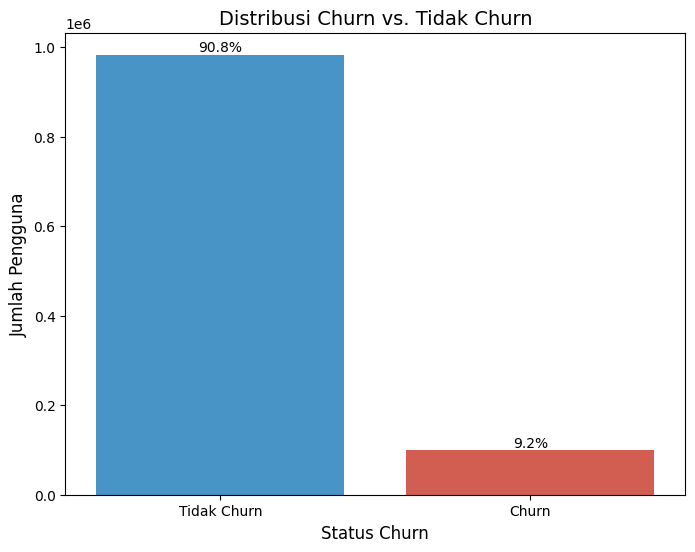

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt  
import seaborn as sns

df_train = pd.read_csv('dataset/train_combined.csv')

plt.figure(figsize=(8, 6))

sns.countplot(x='is_churn', data=df_train, palette={'0': "#3498db", '1': "#e74c3c"})

plt.title('Distribusi Churn vs. Tidak Churn', fontsize=14)
plt.xlabel('Status Churn', fontsize=12)
plt.ylabel('Jumlah Pengguna', fontsize=12)

plt.xticks([0, 1], ['Tidak Churn', 'Churn'])

# tambahin persentase di atas bar
total = len(df_train)
for p in plt.gca().patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    plt.gca().annotate(percentage, (x, y), ha='center', va='bottom')

plt.show()

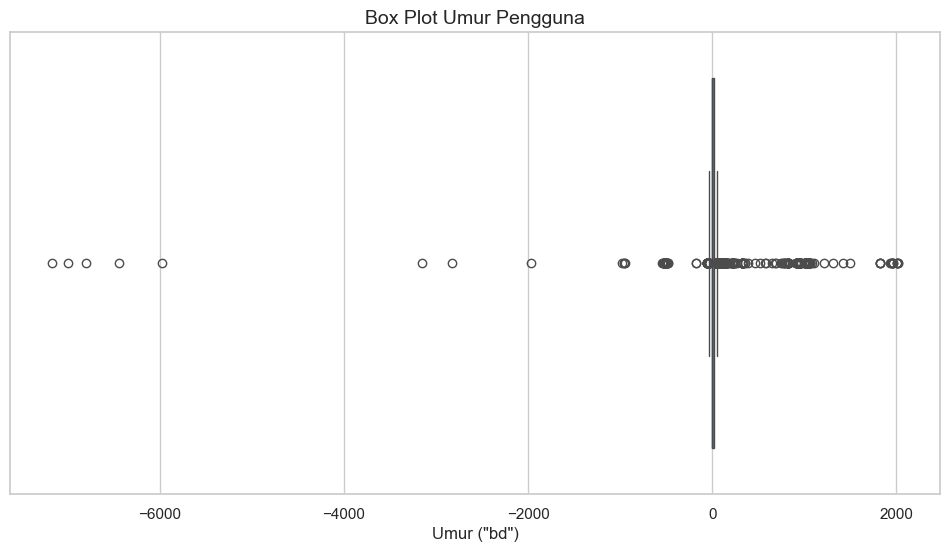

In [ ]:
df_members = pd.read_csv('dataset/members_v3.csv')

plt.figure(figsize=(12, 6))

sns.boxplot(x=df_members['bd'])

plt.title('Box Plot Umur Pengguna', fontsize=14)
plt.xlabel('Umur ("bd")', fontsize=12)
plt.show()

In [ ]:
import pandas as pd
df_members = pd.read_csv('dataset/members_v3.csv')
#  members_df = spark.read.csv(path + 'members_v3.csv', header=True, inferSchema=True)
# 1. Hitung Q1 (Kuartil pertama, 25%) dan Q3 (Kuartil ketiga, 75%)
Q1 = df_members['bd'].quantile(0.25)
Q3 = df_members['bd'].quantile(0.75)

# 2. Hitung IQR (Interquartile Range)
IQR = Q3 - Q1

# 3. Tentukan Batas Bawah dan Batas Atas Outlier
batas_bawah = Q1 - (1.5 * IQR)
batas_atas = Q3 + (1.5 * IQR)

print(f"--- Kalkulasi Outlier untuk 'bd' (Umur) ---")
print(f"Q1 (Kuartil 1): {Q1}")
print(f"Q3 (Kuartil 3): {Q3}")
print(f"IQR (Interquartile Range): {IQR}")
print(f"Batas Bawah (Lower Whisker): {batas_bawah}")
print(f"Batas Atas (Upper Whisker): {batas_atas}")
print("--------------------------------------------------")

# 4. Filter DataFrame untuk menemukan semua baris yang outlier
# Kondisi: Nilai 'bd' < batas_bawah ATAU 'bd' > batas_atas
kondisi_outlier = (df_members['bd'] < batas_bawah) | (df_members['bd'] > batas_atas)
outliers_df = df_members[kondisi_outlier]


# 5. Tampilkan hasilnya (Menjawab pertanyaan Anda)

# Pertanyaan 1: Ada berapa yang outliers?
jumlah_outliers = len(outliers_df)
print(f"\nTotal jumlah outliers: {jumlah_outliers} baris")


# Pertanyaan 2: Masing-masing nilainya berapa aja?
# Opsi A: Tampilkan semua baris yang outlier (jika datanya sedikit)
# print("\nData lengkap outliers:")
# print(outliers_df)

# Opsi B: Tampilkan nilai 'bd' yang unik dari outliers (lebih ringkas)
print(f"\nNilai 'bd' (umur) yang unik dari outliers:")
print(outliers_df['bd'].unique())

# Opsi C: Tampilkan nilai 'bd' unik DAN frekuensinya (paling informatif)
print("\nFrekuensi masing-masing nilai outlier 'bd':")
# .value_counts() akan mengurutkan dari yang paling sering muncul
print(outliers_df['bd'].value_counts().sort_index())

--- Kalkulasi Outlier untuk 'bd' (Umur) ---
Q1 (Kuartil 1): 0.0
Q3 (Kuartil 3): 21.0
IQR (Interquartile Range): 21.0
Batas Bawah (Lower Whisker): -31.5
Batas Atas (Upper Whisker): 52.5
--------------------------------------------------

Total jumlah outliers: 80530 baris

Nilai 'bd' (umur) yang unik dari outliers:
[   63    58    54    56    57    60    59    53   104    64    91    69
    62    55    61    65    75   106   108    99    68    82    95    90
    67    96    77    66   -39    76   109    72    80    93  1028    94
   117    70   793   105   923   107   112    73    87    88    86    71
    81    97    85    79   102   101    78   111    89    74    84   110
    98  -518   -51    83  1037   103   116   100  1025   220    92   115
  1039  1052  -506   938  -510   -36   240  1031   -43   584   944  -958
   137   -48  1032  -515   217  1820  -504  -519   265   143   119   151
   -47   689   183   -42   959   946   -49  -514   122   943  -523  -517
  -482  -520   907   936  1

C:\Users\Jessica Chandra\AppData\Local\Temp\ipykernel_4400\2581218418.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_merged['is_auto_renew'].fillna(0, inplace=True)
C:\Users\Jessica Chandra\AppData\Local\Temp\ipykernel_4400\2581218418.py:23: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='is_auto_renew', y='is_churn', data=df_merged, ci=None,
C:\Users\Jessica Chandra\AppData\Local\Temp\ipykernel_4400\2581218418.py:23: FutureWarning: 

Passing `palette` with

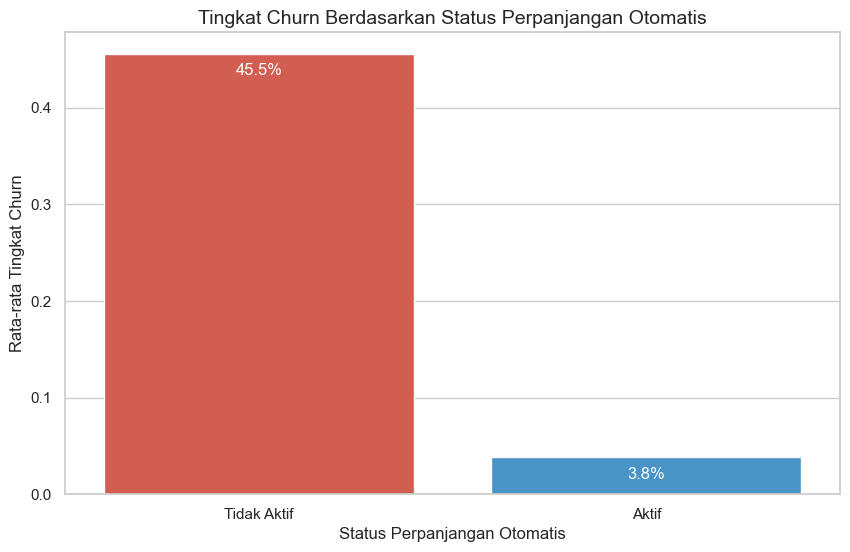

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#  ambil transaksi terakhir untuk setiap pengguna
df_transactions = pd.read_csv('dataset/transactions_v2.csv')
transactions_latest = df_transactions.sort_values('transaction_date').drop_duplicates('msno', keep='last')
df_merged = pd.merge(df_train, transactions_latest[['msno', 'is_auto_renew']], on='msno', how='left')

# CLEANING
# asumsi: pengguna tanpa transaksi berarti tidak auto-renew, jadi isi NaN dengan 0
df_merged['is_auto_renew'].fillna(0, inplace=True)
# balikkin tipe data ke integer spy lebih bersih
df_merged['is_auto_renew'] = df_merged['is_auto_renew'].astype(int)


plt.figure(figsize=(10, 6))

sns.barplot(x='is_auto_renew', y='is_churn', data=df_merged, ci=None,
          palette={'0': "#e74c3c", '1': "#3498db"}) # Merah untuk 0, Biru untuk 1

plt.title('Tingkat Churn Berdasarkan Status Perpanjangan Otomatis', fontsize=14)
plt.xlabel('Status Perpanjangan Otomatis', fontsize=12)
plt.ylabel('Rata-rata Tingkat Churn', fontsize=12)
plt.xticks([0, 1], ['Tidak Aktif', 'Aktif'])

# tambahin persentase di atas bar
for p in plt.gca().patches:
    churn_rate = p.get_height()
    plt.gca().annotate(f'{churn_rate:.1%}',
                       (p.get_x() + p.get_width() / 2., churn_rate),
                       ha='center', va='center', fontsize=12, color='white',
                       xytext=(0, -12), textcoords='offset points')

plt.show()